In [1]:
import sys
sys.path.append('..')
from src.sympy_utilities import *
from src.BinaryEncodings import *
from src.qiskit_utilities import *

In [2]:
h_b_AHO = 0.5*(p*p) + 0.5*(m*q+g*q**3)**2
h_f_AHO = -0.5*(m+3*g*q*q)#[bdag,b]

In [23]:
bqs=4
cutoff=2**bqs
nqubits=bqs+1

hamAHO = Hamiltonian(h_b_AHO, h_f_AHO, {m: 1, g:1},
                    cutoff, standard_encode)

In [24]:
hamAHO.pauliStrings

1426.25*I^0*I^1*I^2*I^3*I^4 + 12.5*I^0*I^1*I^2*I^3*Z^4 - 1225.0*I^0*I^1*I^2*I^4*Z^3 - 6.0*I^0*I^1*I^2*Z^3*Z^4 + 363.45634208808*I^0*I^1*I^3*I^4*X^2 - 672.5*I^0*I^1*I^3*I^4*Z^2 - 3.0*I^0*I^1*I^3*Z^2*Z^4 + 107.736718670147*I^0*I^1*I^4*X^2*X^3 - 331.776851260148*I^0*I^1*I^4*X^2*Z^3 + 107.736718670147*I^0*I^1*I^4*Y^2*Y^3 + 504.0*I^0*I^1*I^4*Z^2*Z^3 + 1024.41570175421*I^0*I^2*I^3*I^4*X^1 - 343.75*I^0*I^2*I^3*I^4*Z^1 + 5.97925362658535*I^0*I^2*I^3*X^1*Z^4 - 1.5*I^0*I^2*I^3*Z^1*Z^4 + 18.0867124111181*I^0*I^2*I^4*X^1*X^3 - 894.1698068383*I^0*I^2*I^4*X^1*Z^3 + 18.0867124111181*I^0*I^2*I^4*Y^1*Y^3 + 252.0*I^0*I^2*I^4*Z^1*Z^3 - 3.0126905805949*I^0*I^2*X^1*Z^3*Z^4 + 492.293118983279*I^0*I^3*I^4*X^1*X^2 - 492.088380396517*I^0*I^3*I^4*X^1*Z^2 - 94.2007809467026*I^0*I^3*I^4*X^2*Z^1 + 438.127973288798*I^0*I^3*I^4*Y^1*Y^2 + 126.0*I^0*I^3*I^4*Z^1*Z^2 + 2.99206489312594*I^0*I^3*X^1*X^2*Z^4 - 1.50951148270479*I^0*I^3*X^1*Z^2*Z^4 + 2.99206489312594*I^0*I^3*Y^1*Y^2*Z^4 + 146.150056485585*I^0*I^4*X^1*X^2*X^3

In [25]:
obsAHOHAM = pauli_string_to_op(hamAHO.pauliStrings)

# 3 repititions of parameterized circuit with ry and rz gates.

In [61]:
from qiskit.circuit.library import EfficientSU2

#for gates in [['ry'],['rz'],...]:
#    for reps in [1,2,3,4,5]:
#        for optimizer in [cobyla,...]:
            
            

var_form = EfficientSU2(nqubits, 
                        su2_gates=['ry'],#,'rz' 
                        entanglement="full", 
                        reps=1)

In [62]:
#currently have an error doing latex with mpl
#var_form.draw(output='mpl')

In [63]:
from qiskit import Aer
from qiskit.utils import algorithm_globals, QuantumInstance
# fix the random seed of the simulator to make values reproducible
seed=50
algorithm_globals.random_seed = seed

# with parallel computation restricted to 2 OpenMP threads (0: maximum)
backend = Aer.get_backend("statevector_simulator", 
                          max_parallel_threads=4, 
                          max_parallel_experiments=0)

# start a quantum instance
q_instance = QuantumInstance(backend, 
                             seed_transpiler=seed, 
                             seed_simulator=seed)

In [64]:
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, NELDER_MEAD, SPSA
from qiskit.algorithms import VQE

import time

# callback functions to store the counts from each iteration of the VQE
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# initital points
#random_init = np.random.random(var_form.num_parameters)
#fixed_init = result.optimal_point

# Setup the VQE algorithm
#vqe = VQE(ansatz=var_form, optimizer=optimizer, initial_point=random_init, quantum_instance=q_instance, callback=store_intermediate_result)
#vqe = VQE(ansatz=var_form, optimizer=optimizer, initial_point=fixed_init, quantum_instance=q_instance, callback=store_intermediate_result)
    
results={}
maxiter=20000
spsaOPT=SPSA(maxiter=maxiter)
bfgsOPT=L_BFGS_B(maxiter=maxiter)
cobylaOPT=COBYLA(maxiter=maxiter)
#optimizers={'SPSA': spsaOPT, 'BFGS': bfgsOPT, 'COBYLA': cobylaOPT,}
optimizers={'COBYLA': cobylaOPT}
    
for name,optimizer in optimizers.items():
    start_time = time.time()
    counts = []
    values = []
    
    vqe = VQE(ansatz=var_form, 
              optimizer=optimizer, 
              quantum_instance=q_instance, 
              callback=store_intermediate_result)

    # run the VQE with out Hamiltonian operator
    # since the VQE is a ground state solver, the syntax is the same as before ;-)
    result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
    vqe_result = np.real(result.eigenvalue)
    print("VQE Result w/ optimizer {}: {}".format(name, vqe_result))

    end_time = time.time()
    runtime = end_time-start_time
    print('Program runtime:',runtime, "s")
    results[name]={'counts': counts, 'values': values}

VQE Result w/ optimizer COBYLA: 0.017761200489296674
Program runtime: 11.219583511352539 s


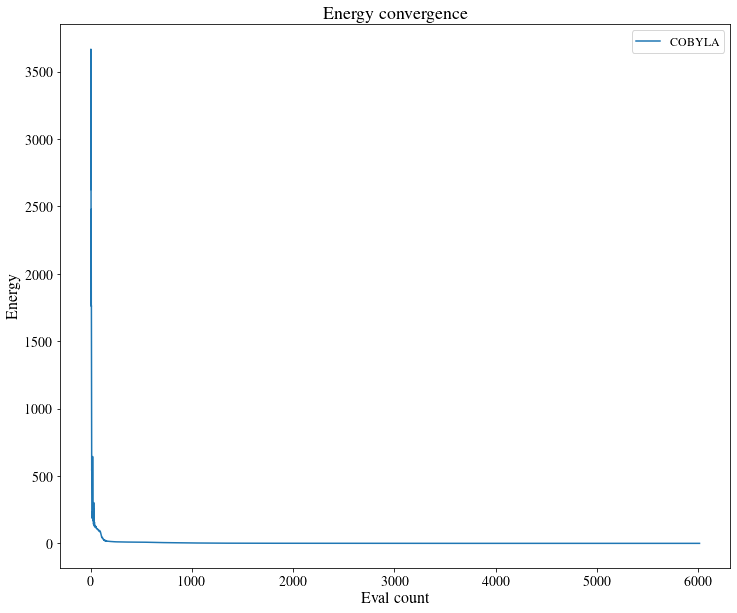

In [66]:
# Plot convergence plot
from matplotlib import pyplot as plt
plt.figure(figsize=(12,10))

for name,data in results.items():
    plt.plot(data['counts'], data['values'], label=name)
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence')
plt.legend(loc='upper right')
plt.show();

In [43]:
len(results['BFGS']['counts'])

1066

In [44]:
len(results['COBYLA']['counts'])

5000

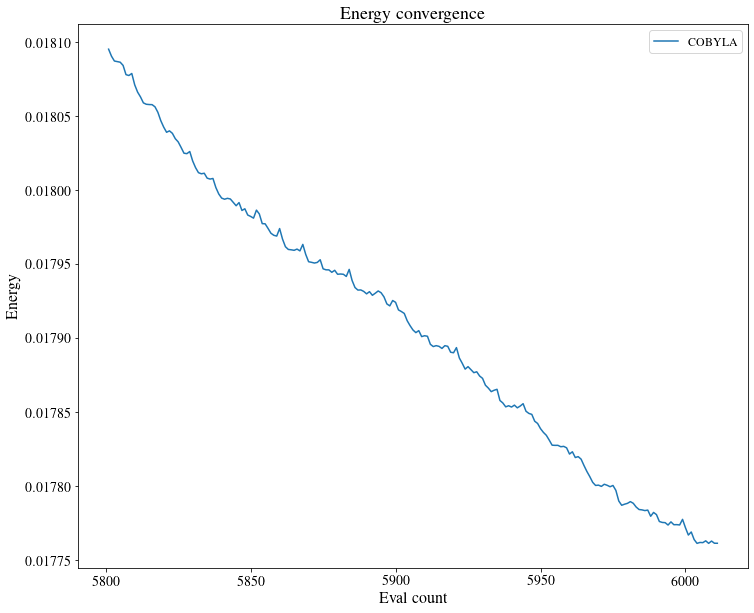

In [68]:
# Plot convergence plot
from matplotlib import pyplot as plt
plt.figure(figsize=(12,10))

start=5800
end=len(results['COBYLA']['counts'])-1
for name,data in results.items():
    if name=='COBYLA':
        plt.plot(data['counts'][start:end], data['values'][start:end], label=name)
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence')
plt.legend(loc='upper right')
plt.show();

# 9 reps of parameterized circuit 

In [47]:
from qiskit.circuit.library import EfficientSU2

var_form = EfficientSU2(nqubits, 
                        su2_gates=['ry','rz'], 
                        entanglement="full", 
                        reps=9)

In [51]:
results={}
maxiter=5000
spsaOPT=SPSA(maxiter=maxiter)
bfgsOPT=L_BFGS_B(maxiter=maxiter)
cobylaOPT=COBYLA(maxiter=maxiter)
optimizers={'SPSA': spsaOPT, 'BFGS': bfgsOPT, 'COBYLA': cobylaOPT,}
    
for name,optimizer in optimizers.items():
    start_time = time.time()
    counts = []
    values = []
    
    vqe = VQE(ansatz=var_form, 
              optimizer=optimizer, 
              quantum_instance=q_instance, 
              callback=store_intermediate_result)

    # run the VQE with out Hamiltonian operator
    # since the VQE is a ground state solver, the syntax is the same as before ;-)
    result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
    vqe_result = np.real(result.eigenvalue)
    print("VQE Result w/ optimizer {}: {}".format(name, vqe_result))

    end_time = time.time()
    runtime = end_time-start_time
    print('Program runtime:',runtime, "s")
    results[name]={'counts': counts, 'values': values}

VQE Result w/ optimizer SPSA: 13.768729886407193
Program runtime: 109.4402403831482 s
VQE Result w/ optimizer BFGS: 92.54558828261739
Program runtime: 10.835388660430908 s
VQE Result w/ optimizer COBYLA: 6.73349585624131
Program runtime: 57.29924178123474 s


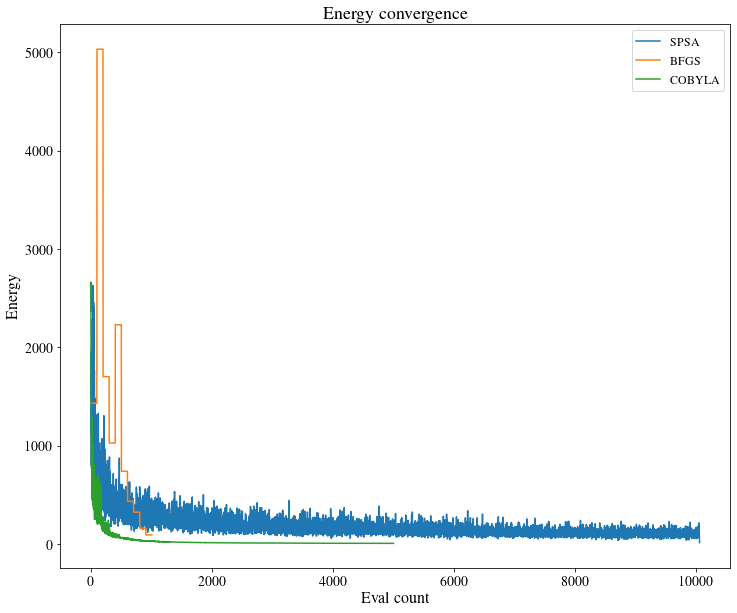

In [52]:
# Plot convergence plot
from matplotlib import pyplot as plt
plt.figure(figsize=(12,10))

for name,data in results.items():
    plt.plot(data['counts'], data['values'], label=name)
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence')
plt.legend(loc='upper right')
plt.show();

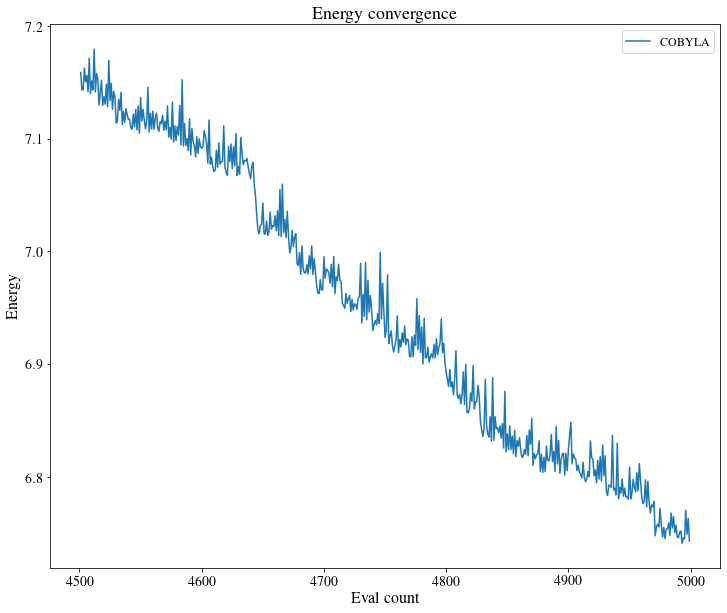

In [53]:
# Plot convergence plot
from matplotlib import pyplot as plt
plt.figure(figsize=(12,10))

start=4500
end=len(results['COBYLA']['counts'])-1
for name,data in results.items():
    if name=='COBYLA':
        plt.plot(data['counts'][start:end], data['values'][start:end], label=name)
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence')
plt.legend(loc='upper right')
plt.show();